In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
df_all = pd.read_pickle('data.pickle')
# 初始化列为 float 类型
df_all['hour_likeCount'] = 0.0
df_all['hour_watchCount'] = 0.0

# 创建布尔索引，标识 live_time_last 不为 0 的行，避免出现0而得到无限大的数值
valid_indices = df_all['live_time_last'] != 0

# 使用布尔索引和向量化操作计算 hour_watchCount 和 hour_likeCount
df_all.loc[valid_indices, 'hour_watchCount'] = (df_all.loc[valid_indices, 'watchCount'] / df_all.loc[valid_indices, 'live_time_last']) * 3600
df_all.loc[valid_indices, 'hour_likeCount'] = (df_all.loc[valid_indices, 'likeCount'] / df_all.loc[valid_indices, 'live_time_last']) * 3600

# 输出平均值
print(df_all['hour_likeCount'].mean(), df_all['hour_watchCount'].mean())

346.223123004971 674.5854626903632


In [23]:
for column in df_all.columns:
    # 空值
    null_count = df_all[column].isnull().sum()

    # 检查字段类型是否为数值型
    if pd.api.types.is_numeric_dtype(df_all[column]):
        # 最大值
        max_value = df_all[column].max()
        
        # 最小值
        min_value = df_all[column].min()
        
        # 平均值
        mean_value = df_all[column].mean()
        
        # 打印字段信息
        print(f"字段名: {column}")
        print(f"空值数量: {null_count}")
        print(f"最大值: {max_value}")
        print(f"最小值: {min_value}")
        print(f"平均值: {mean_value}")
        print(f'字段类型：{type(column)}')
        print()
    else:
        print(f"字段名: {column}")
        print(f"空值数量: {null_count}")
        print("字段不是数值型，无法计算最大值、最小值和平均值")
        print(f'字段类型：{type(column)}')
        print()

字段名: liveId
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: isFinish
空值数量: 0
最大值: True
最小值: False
平均值: 0.9999950775985819
字段类型：<class 'str'>

字段名: isFull
空值数量: 0
最大值: True
最小值: False
平均值: 0.938876695690376
字段类型：<class 'str'>

字段名: parentArea
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: area
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: coverUrl
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: danmakusCount
空值数量: 0
最大值: 275257
最小值: 0
平均值: 1189.399399343967
字段类型：<class 'str'>

字段名: startDate
空值数量: 0
最大值: 1715780200000
最小值: 1580867858000
平均值: 1677069047865.2517
字段类型：<class 'str'>

字段名: stopDate
空值数量: 0
最大值: 1715786365542
最小值: 1580869911000
平均值: 1677080696244.3796
字段类型：<class 'str'>

字段名: title
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: totalIncome
空值数量: 0
最大值: 9210992.4
最小值: 0.0
平均值: 779.8671695022778
字段类型：<class 'str'>

字段名: watchCount
空值数量: 0
最大值: 554220
最小值: 0
平均值: 1725.0120389632684
字段类型：<class 'str'>

字段名: likeCount
空值数量: 0
最大值: 2

In [24]:
df_all['month'] = df_all['start_live_time'].dt.to_period('D').dt.to_timestamp()
# 去掉23年9月后的数据
filter_date = pd.to_datetime('2023-09-01')
df_all_after_timesplit = df_all[df_all['month'] < filter_date]

## 发现很多异常数据：有些主播的收入过高，原因是礼物数量计数错误

解决办法

- 根据主播名分组
- 四分位检测
- zscore
- log化
- 中位数填充

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 定义对数据进行对数变换的函数
def log_transform(df, column):
    df[f'log_{column}'] = np.log(df[column] + 1)
    return df

# IQR方法检测异常值
def detect_outliers_iqr(df, column, outlier_thresh=3.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - outlier_thresh * IQR
    upper_bound = Q3 + outlier_thresh * IQR
    iqr_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return iqr_outliers

# Z-score方法检测异常值
def detect_outliers_zscore(df, column, z_thresh=3):
    df['z_score'] = np.abs(stats.zscore(df[column]))
    z_outliers = df[df['z_score'] > z_thresh]
    return z_outliers

# 结合IQR和Z-score两种方法检测异常值
def detect_outliers_combined(df, column, iqr_thresh=1.5, z_thresh=3):
    df = log_transform(df, column)
    iqr_outliers = detect_outliers_iqr(df, f'log_{column}', iqr_thresh)
    z_outliers = detect_outliers_zscore(df, f'log_{column}', z_thresh)
    
    combined_outliers_index = iqr_outliers.index.intersection(z_outliers.index)
    return df.loc[combined_outliers_index]

# 绘制数据分布图
def plot_data_distribution(df, column, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.boxplot(df[column])
    plt.show()

# 主方法：检测异常值并绘制分布图，补偿被删除的数据
def analyze_and_plot(data, column):
    # 原始数据分布
    plot_data_distribution(data, column, 'Original Data Distribution')

    # 检测异常值
    outliers = detect_outliers_combined(data, column)
    
    # 计算清洗后的中位数
    cleaned_data = data.drop(outliers.index)
    fill_value = cleaned_data[column].median()
    
    # 填充被删除的数据
    data.loc[outliers.index, column] = fill_value

    # 清洗后数据分布
    cleaned_data_after_fill = data
    plot_data_distribution(cleaned_data_after_fill, column, 'Cleaned Data Distribution (after fill)')

    return outliers, cleaned_data_after_fill

# 执行函数
outliers, cleaned_data = analyze_and_plot(df_all_after_timesplit, 'totalIncome')

ModuleNotFoundError: No module named 'scipy'

In [26]:
# 随机打乱数据集
# cdr表示cleaned_data_ramdom
cdr = cleaned_data.sample(frac=1)

1122961    21060.020
691912      2760.636
1376689    17048.000
1127890    17000.354
1396202     7811.690
             ...    
526737     12567.000
89741        181.000
688033      9863.861
983568      8572.522
28999       4412.021
Name: live_time_last, Length: 1107676, dtype: float64
1122961   2022-09-13 18:26:57
691912    2023-03-04 21:18:27
1376689   2021-09-28 21:01:52
1127890   2022-11-08 09:18:02
1396202   2022-12-20 23:13:59
                  ...        
526737    2020-08-29 19:03:55
89741     2021-12-28 21:53:13
688033    2023-07-25 21:24:19
983568    2022-09-22 18:00:32
28999     2023-06-01 15:05:09
Name: start_live_time, Length: 1107676, dtype: datetime64[ns]
1122961   2022-09-14 00:17:57.020
691912    2023-03-04 22:04:27.636
1376689   2021-09-29 01:46:00.000
1127890   2022-11-08 14:01:22.354
1396202   2022-12-21 01:24:10.690
                    ...          
526737    2020-08-29 22:33:22.000
89741     2021-12-28 21:56:14.000
688033    2023-07-26 00:08:42.861
983568    2022-09

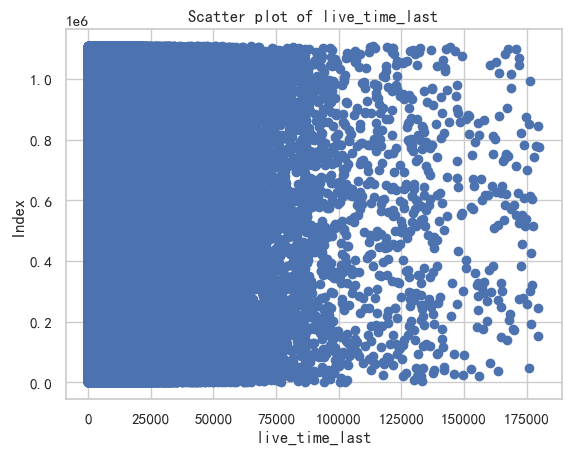

In [27]:
print(cdr['live_time_last'])
print(cdr['start_live_time'])
print(cdr['stop_live_time'])
import matplotlib.pyplot as plt
plt.scatter(cdr['live_time_last'], range(len(cdr)))
plt.ylabel('Index')
plt.xlabel('live_time_last')
plt.title('Scatter plot of '+'live_time_last')
plt.show()

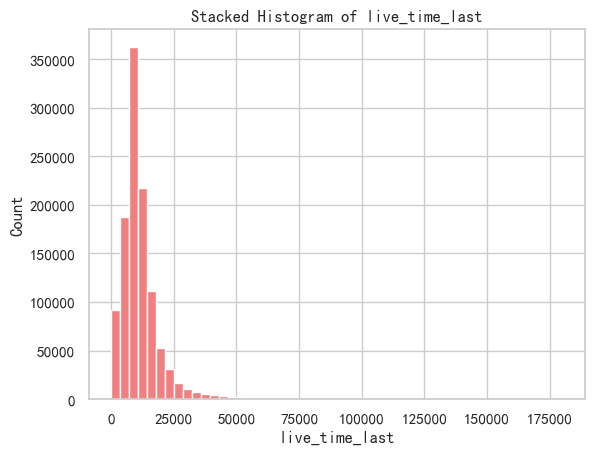

In [28]:
import matplotlib.pyplot as plt

plt.hist(cdr['live_time_last'], bins = 50, stacked=True, color='lightcoral')
plt.xlabel('live_time_last')
plt.ylabel('Count')
plt.title('Stacked Histogram of '+'live_time_last')
plt.show()

In [29]:
max_row = df_all.loc[df_all['live_time_last'].idxmax()]
print(max_row)

liveId                                       b41e2dfb-38ef-44b2-961c-dd418c6740d0
isFinish                                                                     True
isFull                                                                       True
parentArea                                                                   未知分区
area                                                                         未知分区
coverUrl                        https://i0.hdslb.com/bfs/live/new_room_cover/a...
danmakusCount                                                                1086
startDate                                                           1607500025000
stopDate                                                            1607679948000
title                                                                      =w= 惬意
totalIncome                                                                 14.56
watchCount                                                                    163
likeCount       

然而不可思议的是这个直播了将近五十个小时的数据居然不是异常值

<img src="https://p1.meituan.net/csc/73979ac50715ef6c47e9952f9f6b925a5275328.png" width="1280" height="700">

（弹幕数据也是可查的）https://laplace.live/stats/2362016/b41e2dfb-38ef-44b2-961c-dd418c6740d0

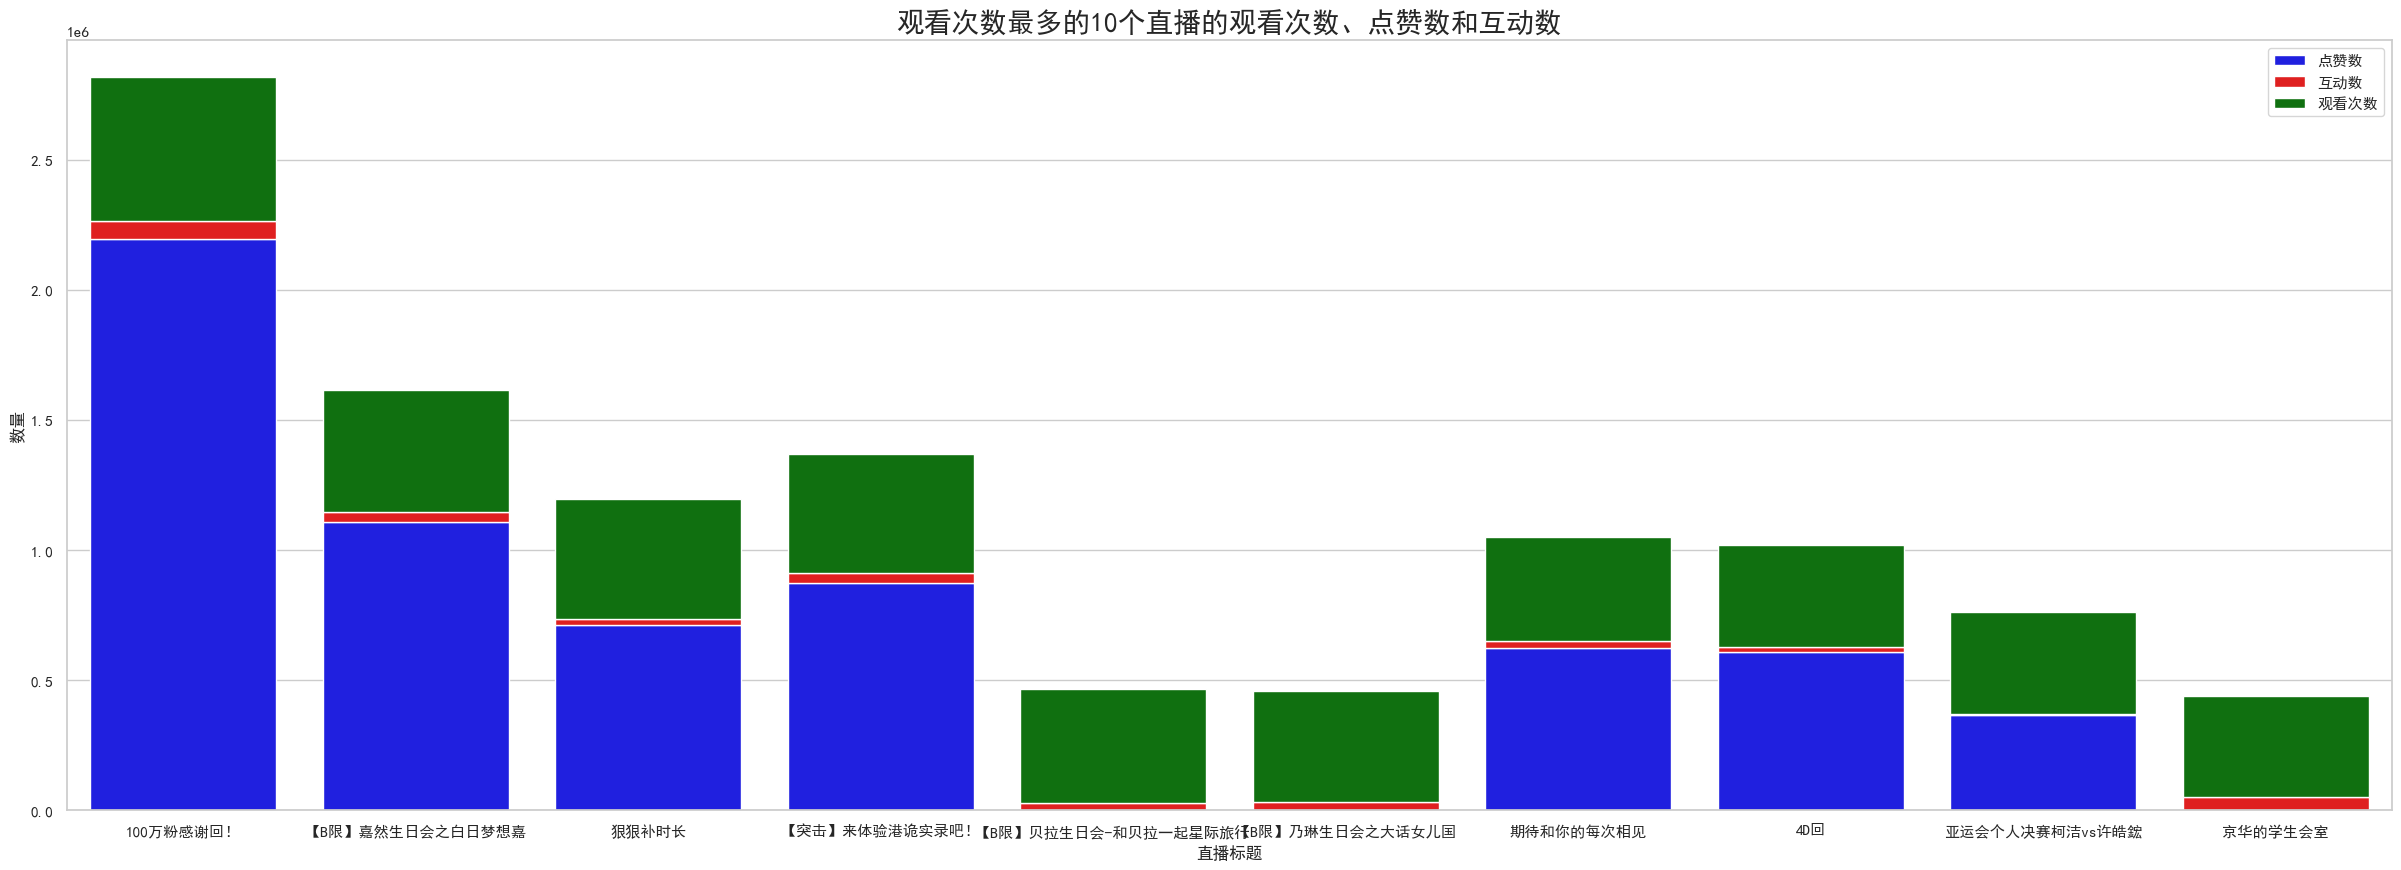

In [30]:
import seaborn as sns

# 创建一个新的Dataframe
data = {'watchCount': [554220, 470168, 460906, 455222, 439796, 428792, 402579, 394542, 391258, 385719],
        'likeCount': [2195076, 1107738, 711368, 875781, 0, 0, 623268, 610691, 368025, 0],
        'interactionCount': [68146, 37063, 24083, 37911, 28412, 31417, 25889, 15556, 3664, 52309],
        'title': ['100万粉感谢回！', '【B限】嘉然生日会之白日梦想嘉', '狠狠补时长', '【突击】来体验港诡实录吧！',
                  '【B限】贝拉生日会-和贝拉一起星际旅行', '【B限】乃琳生日会之大话女儿国', '期待和你的每次相见', '4D回',
                  '亚运会个人决赛柯洁vs许皓鋐', '京华的学生会室']}
df = pd.DataFrame(data)

# 设置风格
sns.set_theme(style='whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 开始绘图
plt.figure(figsize=(30, 10))
plt.title('观看次数最多的10个直播的观看次数、点赞数和互动数', fontsize=20)

# 创建堆叠的条形图
sns.barplot(x='title', y='likeCount', data=df, color='blue', label='点赞数')
sns.barplot(x='title', y='interactionCount', data=df, color='red', bottom = df.likeCount, label='互动数')
sns.barplot(x='title', y='watchCount', data=df, color='green', bottom = df.likeCount + df.interactionCount, label='观看次数')

# 设置图例和标签
plt.legend()
plt.xlabel('直播标题')
plt.ylabel('数量')
plt.show()

In [31]:
grouped_df = cdr.groupby('channel_uName')[['watchCount', 'likeCount', 'interactionCount', 'totalIncome']]
grouped_df_sum = grouped_df.sum()
grouped_df_sum = grouped_df_sum.reset_index()

sorted_by_watchCount = grouped_df_sum.sort_values(by='watchCount', ascending=False)
sorted_by_likeCount = grouped_df_sum.sort_values(by='likeCount', ascending=False)
sorted_by_interactionCount = grouped_df_sum.sort_values(by='interactionCount', ascending=False)
sorted_by_totalIncome = grouped_df_sum.sort_values(by='totalIncome', ascending=False)

print('观看数排行')
print(sorted_by_watchCount.head(20))
print()
print('点赞数排行')
print(sorted_by_likeCount.head(20))
print()
print('互动数排行')
print(sorted_by_interactionCount.head(20))
print()
print('收益排行')
print(sorted_by_totalIncome.head(20))

观看数排行
       channel_uName  watchCount  likeCount  interactionCount  totalIncome
70           Asaki大人    71720842   50642746           6041786   7701743.70
101             C酱です    68806913   13466812           5769713   4433357.40
2880            永雏塔菲    50924707    8085451           4334730   6316319.92
3504   眞白花音_Official    43420906   16337503           3773863   6906970.46
4654        阿梓从小就很可爱    38778318    4711862           5287620   9595773.66
501        七海Nana7mi    34930043    3281937           3863598  13412388.02
368           hanser    28602857   29778963           3230596   2584902.00
4671           阿萨Aza    27299499   33432910           4358337  12681029.10
4047          花花Haya    25960953    2448374           2099059   3755581.56
138      HiiroVTuber    25482187    2964191           3713721   4185330.78
409        shourei小N    22764006    9469728           1406897   1610233.80
887             冰糖IO    20604247    1532945           2582751   6578937.09
4753    雫るる_Officia

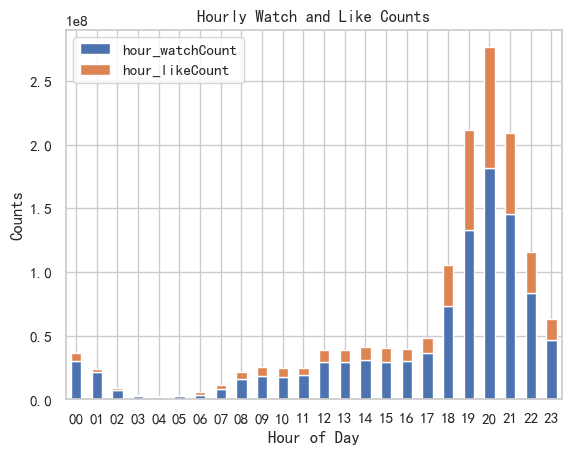

In [32]:
cdr['start_live_time'] = pd.to_datetime(cdr['start_live_time'])
cdr['stop_live_time'] = pd.to_datetime(cdr['stop_live_time'])

# 提取小时部分
cdr['hour'] = cdr['start_live_time'].dt.strftime('%H')

# 使用小时进行分组，并计算hour_watchCount和hour_likeCount的总值
hourly_totals = cdr.groupby('hour').agg({'hour_watchCount': 'sum', 'hour_likeCount': 'sum'})
hourly_totals.plot(kind='bar', stacked=True)
# 添加标题和标签
plt.title('Hourly Watch and Like Counts')
plt.xlabel('Hour of Day')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

In [33]:
grouped = cdr.groupby(['channel_uId', 'channel_uName']).agg({'totalIncome': 'sum', 'title': 'count'}).reset_index()

# 计算每个主播每次直播的平均收益
grouped['avgIncomePerLive'] = grouped['totalIncome'] / grouped['title']
grouped.rename(columns={'title': 'live_times'}, inplace=True)
grouped_sorted = grouped.sort_values(by='avgIncomePerLive', ascending=False)
print('——————————直播效益前二十————————————')
print(grouped_sorted.head(20))

——————————直播效益前二十————————————
           channel_uId    channel_uName  totalIncome  live_times   
4055        1775966996  Vox_EN_Official    904696.70          13  \
3827        1544125954   Mysta_Official    249274.10           4   
3887        1601895109   shoto_official    813873.40          15   
3170         672342685          乃琳Queen   4670087.56         172   
3172         672353429           贝拉kira   4399723.80         173   
2277         351609538          珈乐Carol   1752085.32          69   
3570        1281805827  Fulgur_Official    197604.40           8   
3169         672328094          嘉然今天吃什么   5010303.08         213   
2315         364225566        战斗吧歌姬官方账号   1363978.59          64   
3171         672346917            向晚大魔王   3607560.50         171   
5007  3494357252442916     RO姬_Official    634757.80          32   
2435         401315430      星瞳_Official   2916958.00         168   
2058         194484313          Asaki大人   7701743.70         478   
3951        166977

<Axes: xlabel='parentArea'>

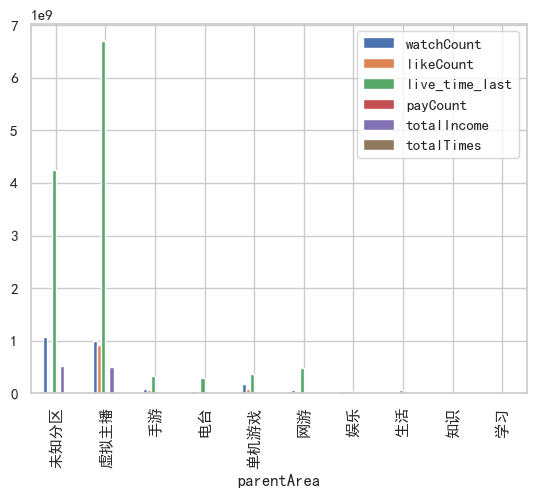

In [34]:
grouped_area = cdr.groupby('parentArea').agg({'watchCount': 'sum', 'likeCount': 'sum', 'live_time_last': 'sum', 'payCount': 'sum', 'totalIncome': 'sum', 'channel_roomId': 'count'})
grouped_area.rename(columns={'channel_roomId': 'totalTimes'}, inplace=True)
grouped_area_sorted = grouped_area.sort_values(by='totalIncome', ascending=False)
plt.rcParams['font.sans-serif'] = ['SimHei']
grouped_area_sorted[0:10].plot(kind='bar')

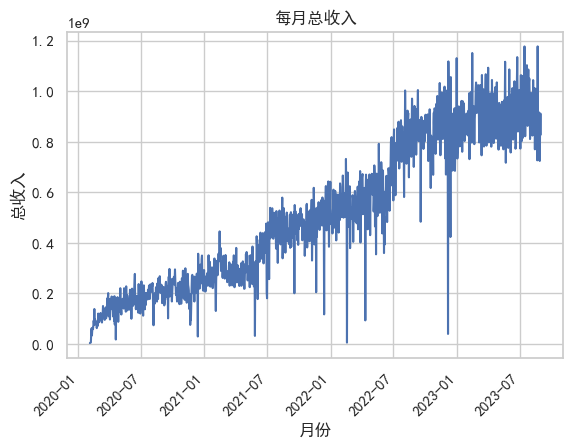

In [35]:
grouped_month = cdr.groupby('month').agg({ 'channel_totalIncome': 'sum'})

# new_grouped_sorted = new_grouped.sort_values(by = 'channel_totalIncome', ascending=False)
# print(new_grouped_sorted)
grouped_month.plot(kind = 'line', legend = False)
plt.title('每月总收入')
plt.xlabel('月份')
plt.ylabel('总收入')
plt.grid(True)
plt.xticks(rotation=45)  # 旋转横轴标签以提高可读性
plt.show()